In [ ]:
import os
import time
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from google.colab import drive
from IPython.display import clear_output

# Montamos Google Drive
drive.mount('/content/drive')

# CONFIGURACIÓN DE DATOS
DRIVE_ZIP_PATH = '/content/drive/MyDrive/TF_AIVA/processed.zip'
TARGET_DIR = '/content/data'

# Crear directorio y descomprimir
if not os.path.exists(TARGET_DIR):
    os.makedirs(TARGET_DIR, exist_ok=True)
    print("Descomprimiendo dataset... (esto mejora la velocidad del vídeo)")
    !unzip -q "{DRIVE_ZIP_PATH}" -d "{TARGET_DIR}"
else:
    print("El directorio ya existe, saltando descompresión.")

# Ruta a las imágenes de TEST descomprimidas
TEST_DATA_DIR = '/content/data/processed/test'

# Ruta al modelo
MODEL_PATH = '/content/drive/MyDrive/TF_AIVA/models/best_screws_classifier.keras'

print(f"\nDatos de test en: {TEST_DATA_DIR}")
print(f"Buscando modelo en: {MODEL_PATH}")

Mounted at /content/drive
Descomprimiendo dataset... (esto mejora la velocidad del vídeo)

Datos de test en: /content/data/processed/test
Buscando modelo en: /content/drive/MyDrive/TF_AIVA/models/best_screws_classifier.keras


In [ ]:
# Cargar el modelo
if not os.path.exists(MODEL_PATH):
    print(f"ERROR: No se encuentra el modelo en {MODEL_PATH}")
    print("Verifica la ruta en la celda anterior.")
else:
    print("Cargando modelo... (esto puede tardar unos segundos)")
    model = load_model(MODEL_PATH)
    print("Modelo cargado correctamente.")

# Detectar las clases automáticamente
# Keras flow_from_directory asigna índices alfabéticamente, así que ordenamos
if os.path.exists(TEST_DATA_DIR):
    class_names = sorted([d for d in os.listdir(TEST_DATA_DIR) if os.path.isdir(os.path.join(TEST_DATA_DIR, d))])
    print(f"Clases detectadas ({len(class_names)}): {class_names}")
else:
    print(f"ERROR: No se encuentra el directorio de test en {TEST_DATA_DIR}")

Cargando modelo... (esto puede tardar unos segundos)
Modelo cargado correctamente.
Clases detectadas (13): ['type_001', 'type_002', 'type_003', 'type_004', 'type_005', 'type_006', 'type_007', 'type_008', 'type_009', 'type_010', 'type_011', 'type_012', 'type_013']


In [ ]:
import tensorflow as tf
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import clear_output, display

# Importaciones específicas de Keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

def demo_video_final(model, path_test_dir, classes, num_samples=10, stop_time = 1.5):

    # Declaramos audit_log como global para poder usarla fuera de la función sin return
    global audit_log

    # OPTIMIZACIÓN DE GPU
    print("Compilando función de inferencia de alto rendimiento...")

    # Definimos la función compilada fuera del bucle para evitar overhead
    @tf.function(reduce_retracing=True)
    def predict_step(images):
        return model(images, training=False)

    # PREPARACIÓN
    classes = sorted(classes)
    idx_to_class = {i: c for i, c in enumerate(classes)}

    all_images = []
    for label in classes:
        class_dir = os.path.join(path_test_dir, label)
        if not os.path.isdir(class_dir): continue
        for file in os.listdir(class_dir):
            if file.endswith(('.png', '.jpg', '.jpeg')):
                all_images.append((os.path.join(class_dir, file), label))

    if not all_images: return

    indices = np.random.choice(len(all_images), num_samples, replace=False)

    # Calentamiento
    print("Calentando GPU con grafo compilado...")
    dummy = tf.zeros((1, 224, 224, 3))
    for _ in range(5):
        _ = predict_step(dummy)
    print("Sistema optimizado. Iniciando demostración...")
    time.sleep(1)

    # Contadores
    audit_log = []
    total_processed = 0
    total_correct = 0

    # BUCLE
    for i, idx in enumerate(indices):
        img_path, true_label = all_images[idx]
        filename = os.path.basename(img_path)

        # Carga y Preprocesamiento
        img_pil = load_img(img_path, target_size=(224, 224))
        img_array = img_to_array(img_pil)
        img_batch = np.expand_dims(img_array, axis=0)
        img_preprocessed = preprocess_input(img_batch.copy())

        # Convertir a Tensor
        img_tensor = tf.convert_to_tensor(img_preprocessed, dtype=tf.float32)

        # INFERENCIA
        start = time.time()

        # Llamamos a la función compilada
        pred_tensor = predict_step(img_tensor)

        # Sincronizamos
        pred = pred_tensor.numpy()

        end = time.time()

        inference_time_ms = (end - start) * 1000

        # Decodificar
        pred_idx = np.argmax(pred)
        pred_label = idx_to_class[pred_idx]
        confidence = np.max(pred) * 100
        is_correct = (pred_label == true_label)

        # Acumulados
        total_processed += 1
        if is_correct: total_correct += 1
        current_acc = (total_correct / total_processed) * 100

        # Log de datos
        timestamp = datetime.now().strftime("%H:%M:%S")
        log_entry = {
            "Time": timestamp, "Pieza": filename, "Real": true_label,
            "Pred": pred_label, "Conf": f"{confidence:.1f}%",
            "Latencia": f"{inference_time_ms:.1f}ms", "Estado": "OK" if is_correct else "FALLO"
        }
        audit_log.append(log_entry)

        # VISUALIZACIÓN
        clear_output(wait=True)
        fig = plt.figure(figsize=(5, 6))
        gs = fig.add_gridspec(2, 1, height_ratios=[1, 8])

        # Barra de progreso
        ax_bar = fig.add_subplot(gs[0])
        bar_color = '#00cc00' if current_acc >= 95 else ('#ff9900' if current_acc >= 85 else '#cc0000')
        ax_bar.barh(0, 100, color='#eeeeee', height=0.7)
        ax_bar.barh(0, current_acc, color=bar_color, height=0.7)
        ax_bar.set_xlim(0, 100); ax_bar.axis('off')
        ax_bar.set_title(f"PRECISIÓN ACUMULADA: {current_acc:.1f}% ({total_correct}/{total_processed})",
                         fontsize=11, fontweight='bold', color='#333333', pad=4)

        # Imagen
        ax_img = fig.add_subplot(gs[1])
        ax_img.imshow(img_pil)
        ax_img.axis('off')

        color_status = 'green' if is_correct else 'red'
        status_text = "APROBADO" if is_correct else "RECHAZADO"

        info = (f"HORA: {timestamp}\nREAL: {true_label}\nPRED: {pred_label}\n"
                f"CONF: {confidence:.1f}%\nLATENCIA: {inference_time_ms:.1f} ms")

        ax_img.text(10, 10, info, fontsize=10,
                 bbox=dict(facecolor='black', alpha=0.7, edgecolor='white', pad=4),
                 color='lime', verticalalignment='top', fontname='monospace')

        ax_img.set_title(f"ESTADO: {status_text}",
                  fontsize=12, backgroundcolor=color_status, color='white', weight='bold', pad=8)

        plt.tight_layout()
        plt.show()
        plt.close(fig)
        print(f"LOG > {timestamp} | {filename} | {inference_time_ms:.1f}ms")

        # Pequeña pausa para ver el vídeo
        if stop_time != 0:
            time.sleep(stop_time)

    print(f"\nFIN. PRECISIÓN FINAL: {current_acc:.1f}%")
    display(pd.DataFrame(audit_log))


# Ejecución detenida para ver el procesamiento detalladamente

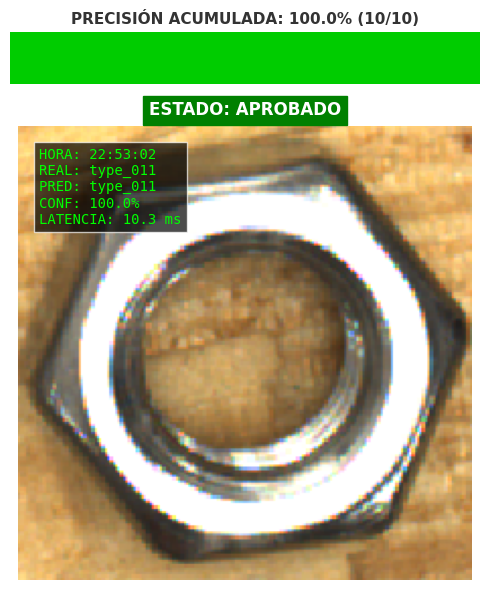

LOG > 22:53:02 | 33_33003.png | 10.3ms

FIN. PRECISIÓN FINAL: 100.0%


,Time,Pieza,Real,Pred,Conf,Latencia,Estado
0,22:52:46,37_37004.png,type_011,type_011,100.0%,7.7ms,OK
1,22:52:48,57_57009.png,type_005,type_005,97.3%,9.0ms,OK
2,22:52:50,30_30002.png,type_008,type_008,99.9%,8.4ms,OK
3,22:52:51,3_3003.png,type_006,type_006,100.0%,7.7ms,OK
4,22:52:53,50_50004.png,type_007,type_007,99.9%,7.8ms,OK
5,22:52:55,10_10004.png,type_011,type_011,100.0%,7.6ms,OK
6,22:52:56,55_55007.png,type_010,type_010,88.4%,9.6ms,OK
7,22:52:58,12_12004.png,type_007,type_007,100.0%,7.6ms,OK
8,22:53:00,15_15004.png,type_002,type_002,99.9%,9.1ms,OK
9,22:53:02,33_33003.png,type_011,type_011,100.0%,10.3ms,OK


In [26]:
demo_video_final(model, TEST_DATA_DIR, class_names) # Mostramos por defecto 10 piezas

# Ejecución sin detener procesando 100 imágenes

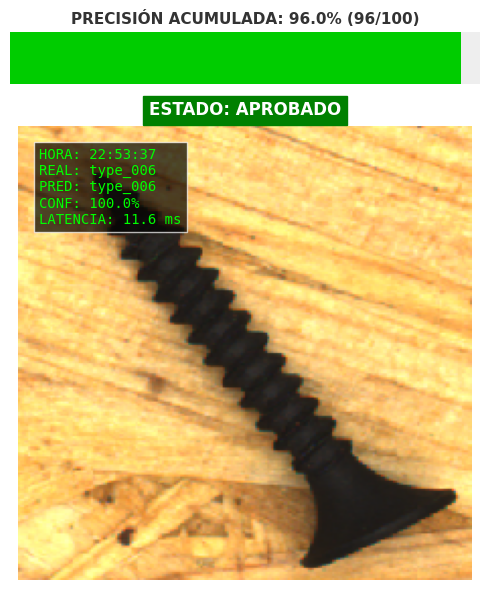

LOG > 22:53:37 | 3_3007.png | 11.6ms

FIN. PRECISIÓN FINAL: 96.0%


,Time,Pieza,Real,Pred,Conf,Latencia,Estado
0,22:53:12,39_39001.png,type_009,type_009,100.0%,12.0ms,OK
1,22:53:12,49_49008.png,type_003,type_003,100.0%,16.2ms,OK
2,22:53:12,59_59010.png,type_006,type_006,100.0%,13.8ms,OK
3,22:53:13,29_29002.png,type_008,type_008,100.0%,25.1ms,OK
4,22:53:13,16_16002.png,type_004,type_004,100.0%,10.4ms,OK
...,...,...,...,...,...,...,...
95,22:53:36,11_11004.png,type_006,type_006,100.0%,10.4ms,OK
96,22:53:36,28_28012.png,type_002,type_002,99.4%,9.1ms,OK
97,22:53:36,57_57007.png,type_005,type_005,96.3%,10.5ms,OK
98,22:53:37,28_28009.png,type_004,type_004,97.7%,13.8ms,OK


In [27]:
demo_video_final(model, TEST_DATA_DIR, class_names, num_samples=100, stop_time=0)

# RESUMEN DE LA EJECUCIÓN

In [28]:
# Accedemos a la variable global audit_log
if 'audit_log' in globals() and audit_log:
    df_results = pd.DataFrame(audit_log)

    # Limpieza y conversión de latencia
    df_results['Lat_num'] = df_results['Latencia'].astype(str).str.replace('ms', '').astype(float)

    acc_final = (df_results['Estado'] == 'OK').mean() * 100
    lat_media = df_results['Lat_num'].mean()
    fps_reales = 1000 / lat_media

    print(f"- Piezas procesadas:        {len(df_results)}")
    print(f"- Precisión en tiempo real: {acc_final:.2f}%")
    print(f"- Latencia media:           {lat_media:.2f} ms")
    print(f"- Capacidad del sistema:    {fps_reales:.2f} FPS")
    print("-" * 45)

    if lat_media < 108:
        print(f"ESTADO: CUMPLE REQUISITO (Margen: +{108 - lat_media:.1f} ms)")
else:
    print("El log está vacío. Ejecuta la función demo_video_final primero.")

- Piezas procesadas:        100
- Precisión en tiempo real: 96.00%
- Latencia media:           11.73 ms
- Capacidad del sistema:    85.25 FPS
---------------------------------------------
ESTADO: CUMPLE REQUISITO (Margen: +96.3 ms)
